In [1]:
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
from pylab import rcParams
import numpy as np
from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima
from pmdarima. arima import ARIMA
import statsmodels.api as sm

In [2]:
msft = yf.Ticker("MSFT")

In [3]:
msft.info

{'address1': 'One Microsoft Way',
 'city': 'Redmond',
 'state': 'WA',
 'zip': '98052-6399',
 'country': 'United States',
 'phone': '425 882 8080',
 'fax': '425 706 7329',
 'website': 'https://www.microsoft.com',
 'industry': 'Software—Infrastructure',
 'industryDisp': 'Software—Infrastructure',
 'sector': 'Technology',
 'longBusinessSummary': 'Microsoft Corporation develops, licenses, and supports software, services, devices, and solutions worldwide. The company operates in three segments: Productivity and Business Processes, Intelligent Cloud, and More Personal Computing. The Productivity and Business Processes segment offers Office, Exchange, SharePoint, Microsoft Teams, Office 365 Security and Compliance, Microsoft Viva, and Skype for Business; Skype, Outlook.com, OneDrive, and LinkedIn; and Dynamics 365, a set of cloud-based and on-premises business solutions for organizations and enterprise divisions. The Intelligent Cloud segment licenses SQL, Windows Servers, Visual Studio, Syst

In [4]:
yf.pdr_override()
data = pdr.get_data_yahoo("MSFT", start="2022-05-19", end="2023-05-20")
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-05-19,253.899994,257.670013,251.880005,253.139999,250.716522,32692300
2022-05-20,257.239990,258.540009,246.440002,252.559998,250.142075,39199300
2022-05-23,255.490005,261.500000,253.429993,260.649994,258.154602,33175400
2022-05-24,257.890015,261.329987,253.500000,259.619995,257.134491,29043900
2022-05-25,258.140015,264.579987,257.130005,262.519989,260.006683,28547900
...,...,...,...,...,...,...
2023-05-15,309.100006,309.899994,307.589996,309.459991,308.784973,16336500
2023-05-16,309.829987,313.709991,309.829987,311.739990,311.059998,26730300
2023-05-17,312.290009,314.429993,310.739990,314.000000,314.000000,24315000


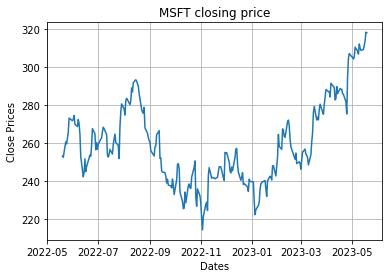

In [5]:
# plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title('MSFT closing price')
plt.show()

In [6]:
# First, we need to check if a series is stationary or not because time series analysis only works with stationary data.
# Ho: It is non-stationary
# H1: It is stationary

In [7]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC') # Augmented Dickey-Fuller test
    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

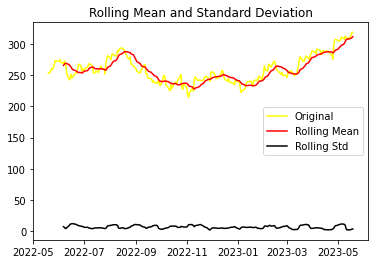

Results of dickey fuller test
Test Statistics                 -0.791615
p-value                          0.821573
No. of lags used                 2.000000
Number of observations used    249.000000
critical value (1%)             -3.456888
critical value (5%)             -2.873219
critical value (10%)            -2.572994
dtype: float64


In [8]:
test_stationarity(data['Close']) # result is 0.82 which is higher than 0.5 so we cannot reject null hypothesis

In [9]:
# method 2 'pmdarima' package for ADFTest.
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(data['Close'])

(0.9239940526271446, True)

<Figure size 432x288 with 0 Axes>

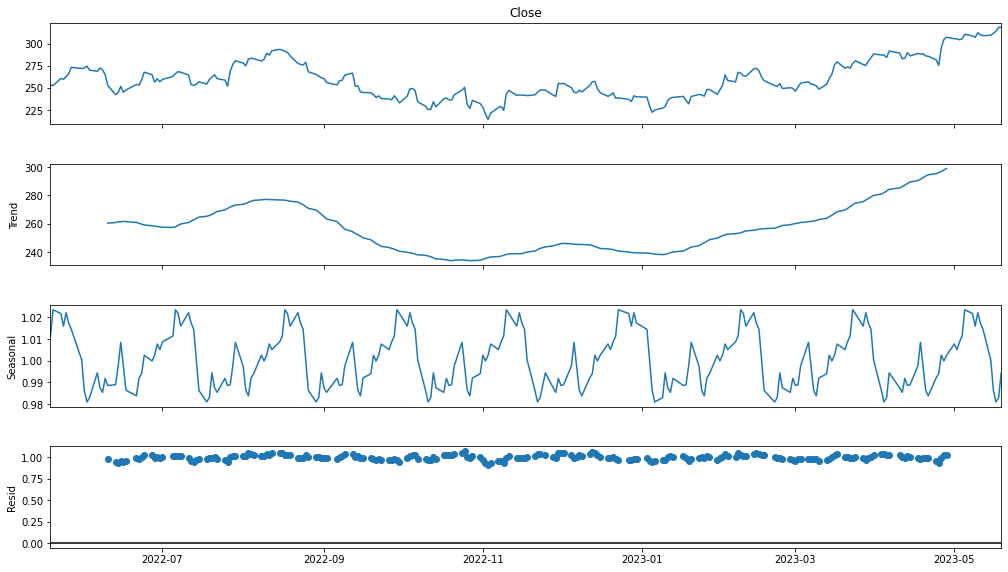

In [10]:
result = seasonal_decompose(data['Close'], model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()
fig.set_size_inches(16, 9)

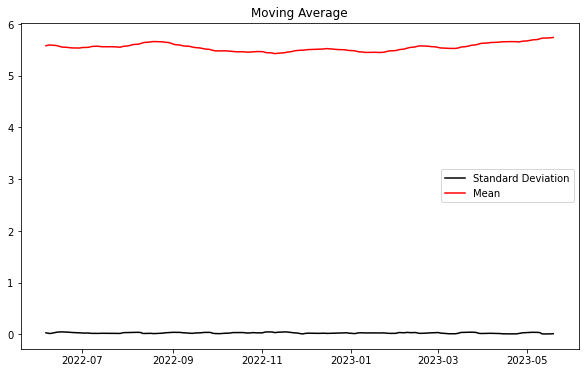

In [11]:
rcParams['figure.figsize'] = 10, 6
df_log = np.log(data['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
# plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

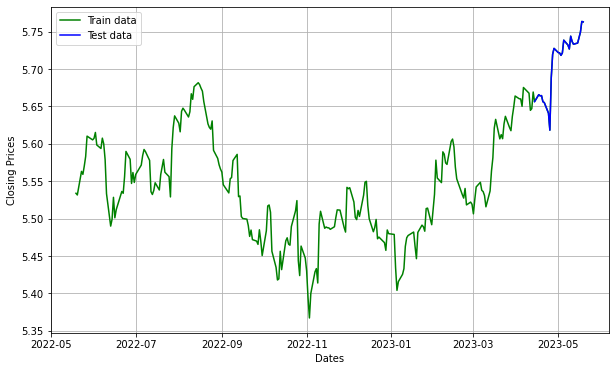

In [12]:
train_data, test_data = df_log[:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [13]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
test='adf',       # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1,              # frequency of series
d=None,           # let model determine 'd'
seasonal=False,   # No Seasonality
start_P=0, 
D=0, 
trace=True,
error_action='ignore',  
suppress_warnings=True, 
stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1094.945, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1095.112, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1096.160, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1096.761, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1096.843, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1098.728, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1100.278, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1098.633, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1096.593, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1102.083, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1096.956, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-1100.420, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1100.507, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1098.689, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0

In [19]:
# second shot
arima_model = auto_arima(train_data,start_p=0, d=1, start_q=0,
max_p=5, max_d=5, max_q=5, start_P=0,
D=1, start_Q=0, max_P=5, max_D=5,
max_Q=5, m=12, seasonal=True,
error_action='warn',trace = True,
supress_warnings=True, stepwise = True,
random_state=20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-880.734, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-925.294, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-881.619, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-953.921, Time=0.47 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-969.688, Time=1.28 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=-976.220, Time=2.87 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=-987.760, Time=5.91 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=-991.851, Time=9.56 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=6.07 sec
 ARIMA(1,1,0)(5,1,2)[12]             : AIC=-990.878, Time=13.55 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=inf, Time=8.08 sec
 ARIMA(0,1,0)(5,1,1)[12]             : AIC=-993.023, Time=9.08 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=inf, Time=5.87 sec
 ARIMA(0,1,0)(5,1,0)[12]             :

In [20]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  226
Model:             SARIMAX(0, 1, 0)x(5, 1, [1], 12)   Log Likelihood                 503.511
Date:                              Sun, 21 May 2023   AIC                           -993.023
Time:                                      14:25:02   BIC                           -969.494
Sample:                                           0   HQIC                          -983.514
                                              - 226                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.3095      0.180     -1.723      0.085      -0.662       0.043
ar.S.L24      -0.4035      0.160     -2.530      0.011      -0.716      -0.091
ar.S.L36      -0.2879      0.166     -1.736      0.083      -0.613       0.037
ar.S.L48      -0.1860      0.139     -1.334      0.182      -0.459       0.087
ar.S.L60      -0.1655      0.117     -1.417      0.156      -0.394       0.063
ma.S.L12      -0.6331      0.178     -3.563      0.000      -0.981      -0.285
sigma2         0.0005   4.36e-05     10.789      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   1.29   Jarque-Bera (JB):                12.20
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.25
Prob(H) (two-sided):                  0.69   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 1), index=test_data.index)
prediction.columns = ['predicted sales']
prediction

/Users/jennyhuang/yes/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/jennyhuang/yes/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,predicted sales
Date,
2023-04-14,NaN
2023-04-17,NaN
2023-04-18,NaN
2023-04-19,NaN
2023-04-20,NaN
2023-04-21,NaN
2023-04-24,NaN
2023-04-25,NaN
2023-04-26,NaN


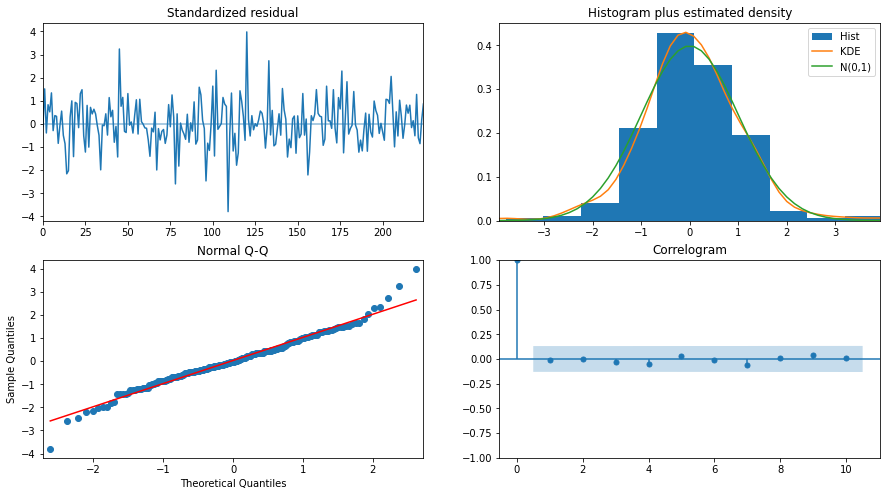

In [14]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [15]:
model_autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  226
Model:               SARIMAX(2, 1, 0)   Log Likelihood                 554.041
Date:                Sun, 21 May 2023   AIC                          -1102.083
Time:                        16:57:20   BIC                          -1091.834
Sample:                             0   HQIC                         -1097.946
                                - 226                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1172      0.077      1.525      0.127      -0.033       0.268
ar.L2         -0.1769      0.067     -2.629      0.009      -0.309      -0.045
sigma2         0.0004   3.07e-05     13.854      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                28.15
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             0.10
Prob(H) (two-sided):                  0.56   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
prediction = pd.DataFrame(model_autoARIMA.predict(n_periods = 30), index=test_data.index)
prediction.columns = ['predicted sales']
prediction

/Users/jennyhuang/yes/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/jennyhuang/yes/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,predicted sales
Date,
2023-04-14,NaN
2023-04-17,NaN
2023-04-18,NaN
2023-04-19,NaN
2023-04-20,NaN
2023-04-21,NaN
2023-04-24,NaN
2023-04-25,NaN
2023-04-26,NaN


In [18]:
model = sm.tsa.arima.ARIMA(train_data, order=(2, 1, 0))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 554.041
Date:                Sun, 21 May 2023   AIC                          -1102.083
Time:                        16:57:41   BIC                          -1091.834
Sample:                             0   HQIC                         -1097.946
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1172      0.077      1.525      0.127      -0.033       0.268
ar.L2         -0.1769      0.067     -2.629      0.009      -0.309      -0.045
sigma2         0.0004   3.07e-05     13.854      0.0

/Users/jennyhuang/yes/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jennyhuang/yes/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jennyhuang/yes/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/Users/jennyhuang/yes/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/jennyhuang/yes/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/jennyhuang/yes/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


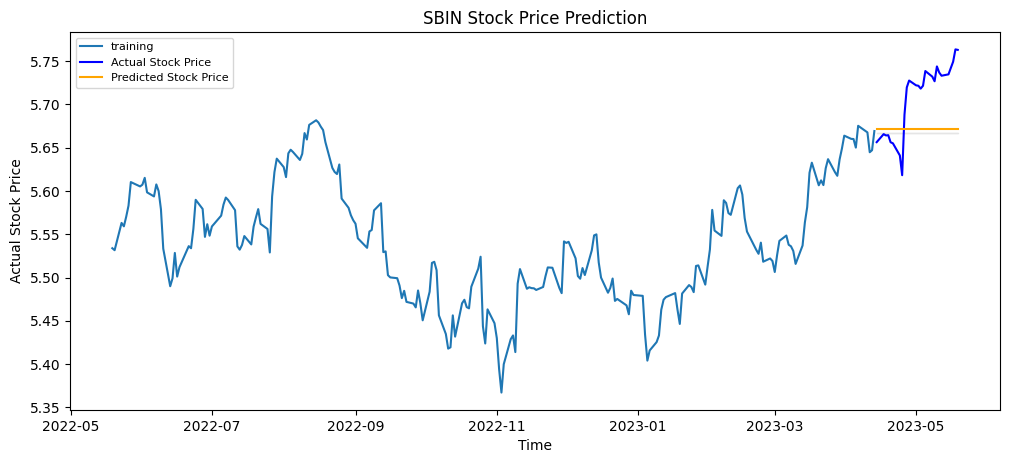

In [19]:
fc, se, conf = fitted.forecast(3, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf, index=test_data.index)
upper_series = pd.Series(conf, index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('SBIN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()